<center><h1>Wadhwani_Harshil_Project</h1></center>

Name: Harshil Wadhwani<br>
Github Username: harshilw24<br>
USC ID: 5263982925<br>

In [ ]:
#!unzip /content/drive/MyDrive/552/data.zip

### Import

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import os.path as op
import json
import shutil
import logging
from tqdm import tqdm
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import cv2
import random
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

### Data Processing

In [5]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [6]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/552/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/552/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/552/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [7]:
def augment_image(image, target_size):
    # Ensure the image is in the correct format
    image = tf.cast(image, tf.float32)

    # Randomly apply a horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Randomly change the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Randomly change the contrast of the image
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Randomly adjust saturation
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)

    # Ensure the image is resized to the target size
    image = tf.image.resize(image, [target_size[0], target_size[1]])

    return image

In [8]:
def load_and_preprocess(img_loc, label, is_training=False):

    def _inner_function(img_loc, label, is_training):
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)  # Convert PIL image to numpy array
        img = tf.convert_to_tensor(img, dtype=tf.float32)  # Convert numpy array to TensorFlow tensor



        if is_training:
            img = augment_image(img, (299,299))  # Apply augmentations for training images

        img = tf.image.resize(img, IMAGE_SIZE)
        img.set_shape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

        return img, 1 if label_str == 'frost' else 0


    X, y = tf.py_function(_inner_function, [img_loc, label, is_training], [tf.float32, tf.int64])
    X.set_shape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    y.set_shape(())
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(lambda x, y: load_and_preprocess(x, y, True), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(lambda x, y: load_and_preprocess(x, y, False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(lambda x, y: load_and_preprocess(x, y, False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

### Training

#### STEP 1: IMAGE AUGMENTATION

I've implemented some image augmentations for our training data. I created a function called "augment_image" to specify the changes we want to apply, such as flipping, rotating, and adjusting brightness. This helps our model handle images in various conditions.

When loading images using "load_and_preprocess," I converted them into TensorFlow tensors for compatibility. I also made sure to apply augmentations only to training data, not validation or test data. This diversifies our training set.

For validation and test datasets, I kept the images unchanged to assess the model accurately. After all this, I shuffled and grouped the images into batches for training and evaluation.

The augmentation process highlighted has been implemented within the data pre processing code segment to augment the images in the training data before the batching process.

#### STEP 2: BUILDING AND TRAINING

In [10]:
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(299, 299, 3), kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Flatten(),

    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.3),

    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=20, restore_best_weights=True)

history = model.fit(
    tf_dataset_train,
    validation_data=tf_dataset_val,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
928/928 [==============================] - 390s 400ms/step - loss: 1.0517 - accuracy: 0.7650 - val_loss: 0.6109 - val_accuracy: 0.9243
Epoch 2/30
928/928 [==============================] - 397s 427ms/step - loss: 0.6425 - accuracy: 0.8520 - val_loss: 1.0709 - val_accuracy: 0.6792
Epoch 3/30
928/928 [==============================] - 408s 438ms/step - loss: 0.4824 - accuracy: 0.8985 - val_loss: 1.2107 - val_accuracy: 0.6334
Epoch 4/30
928/928 [==============================] - 364s 392ms/step - loss: 0.4045 - accuracy: 0.9171 - val_loss: 6.0044 - val_accuracy: 0.3317
Epoch 5/30
928/928 [==============================] - 383s 413ms/step - loss: 0.3528 - accuracy: 0.9329 - val_loss: 0.3684 - val_accuracy: 0.9055
Epoch 6/30
928/928 [==============================] - 360s 388ms/step - loss: 0.3144 - accuracy: 0.9457 - val_loss: 1.2387 - val_accuracy: 0.6349
Epoch 7/30
928/928 [==============================] - 387s 417ms/step - loss: 0.2910 - accuracy: 0.9532 - val_loss: 0.9514 -

#### STEP 3: PLOTTING TRAINING AND VALIDATION ERRORS

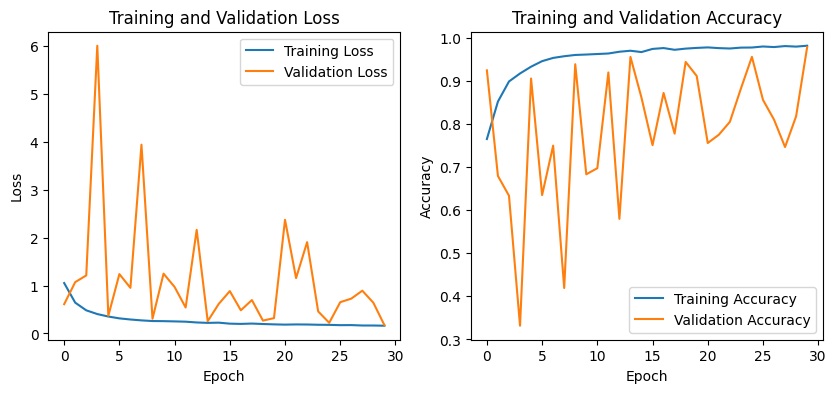

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### STEP 4: PRECISION

In [12]:
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    predicted_probs = model.predict(images, verbose=0)
    preds = np.argmax(predicted_probs, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculating metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

# Printing metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.9747368421052631
Recall: 0.8813801308744795
F1 Score: 0.925710715401437
Accuracy: 0.9072759884582391


### Transfer Learning

16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/20
928/928 [==============================] - 402s 413ms/step - loss: 0.1283 - accuracy: 0.9507 - val_loss: 0.2718 - val_accuracy: 0.8897
Epoch 2/20
928/928 [==============================] - 382s 412ms/step - loss: 0.0678 - accuracy: 0.9748 - val_loss: 0.3187 - val_accuracy: 0.8794
Epoch 3/20
928/928 [==============================] - 365s 393ms/step - loss: 0.0505 - accuracy: 0.9826 - val_loss: 0.3512 - val_accuracy: 0.8853
Epoch 4/20
928/928 [==============================] - 365s 393ms/step - loss: 0.0449 - accuracy: 0.9837 - val_loss: 0.4849 - val_accuracy: 0.8575
Epoch 5/20
928/928 [==============================] - 365s 393ms/step - loss: 0.0395 - accuracy: 0.9861 - val_loss: 0.3942 - val_accuracy: 0.8723
Epoch 6/20
928/928 [==============================] - 364s 392ms/step - loss: 0.0352 - accuracy: 0.9866 - val_loss: 0.3619 - val_accuracy: 0.8871
Epoch 7/20
928/928 [==============================] - 377s 

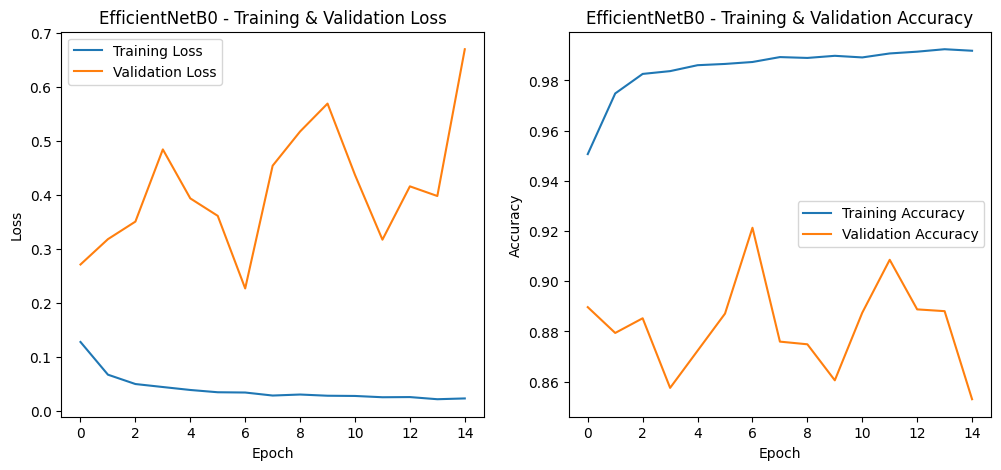

In [8]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

model_efficientnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model_efficientnet.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10, restore_best_weights=True)

history_efficientnet = model_efficientnet.fit(
    tf_dataset_train,
    validation_data=tf_dataset_val,
    epochs=20,
    callbacks=[early_stopping]
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['loss'], label='Training Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0 - Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    predicted_probs = model_efficientnet.predict(images, verbose=0)
    preds = np.argmax(predicted_probs, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.9636920900624779
Recall: 0.9726353361094586
F1 Score: 0.9681430601610611
Accuracy: 0.9580441394369492


94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/20
928/928 [==============================] - 403s 428ms/step - loss: 0.1051 - accuracy: 0.9602 - val_loss: 0.6083 - val_accuracy: 0.8175
Epoch 2/20
928/928 [==============================] - 387s 416ms/step - loss: 0.0475 - accuracy: 0.9830 - val_loss: 0.5969 - val_accuracy: 0.8363
Epoch 3/20
928/928 [==============================] - 388s 417ms/step - loss: 0.0342 - accuracy: 0.9884 - val_loss: 0.6919 - val_accuracy: 0.8450
Epoch 4/20
928/928 [==============================] - 389s 419ms/step - loss: 0.0270 - accuracy: 0.9903 - val_loss: 0.6576 - val_accuracy: 0.8475
Epoch 5/20
928/928 [==============================] - 389s 418ms/step - loss: 0.0259 - accuracy: 0.9908 - val_loss: 0.6472 - val_accuracy: 0.8593
Epoch 6/20
928/928 [==============================] - 390s 420ms/step - loss: 0.0203 - accuracy: 0.9928 - val_loss: 0.6495 - val_accuracy: 0.8566
Epoch 7/20
928/928 [==============================] - 386s 

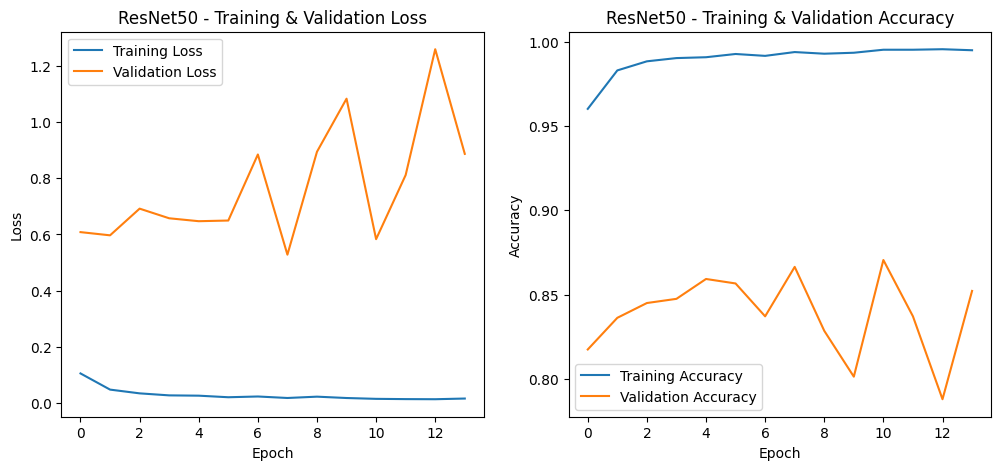

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

model_resnet50 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model_resnet50.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10, restore_best_weights=True)

history_resnet50 = model_resnet50.fit(
    tf_dataset_train,
    validation_data=tf_dataset_val,
    epochs=20,
    callbacks=[early_stopping]
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 - Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    predicted_probs = model_resnet50.predict(images, verbose=0)
    preds = np.argmax(predicted_probs, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.940105359596885
Recall: 0.9766805472932778
F1 Score: 0.9580439983661083
Accuracy: 0.9439288777977073


58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/20
928/928 [==============================] - 441s 454ms/step - loss: 0.1809 - accuracy: 0.9280 - val_loss: 0.4442 - val_accuracy: 0.7946
Epoch 2/20
928/928 [==============================] - 405s 436ms/step - loss: 0.0994 - accuracy: 0.9639 - val_loss: 0.3274 - val_accuracy: 0.8546
Epoch 3/20
928/928 [==============================] - 409s 440ms/step - loss: 0.0781 - accuracy: 0.9714 - val_loss: 0.3578 - val_accuracy: 0.8522
Epoch 4/20
928/928 [==============================] - 419s 451ms/step - loss: 0.0665 - accuracy: 0.9769 - val_loss: 0.5175 - val_accuracy: 0.8151
Epoch 5/20
928/928 [==============================] - 404s 435ms/step - loss: 0.0574 - accuracy: 0.9792 - val_loss: 0.4745 - val_accuracy: 0.8238
Epoch 6/20
928/928 [==============================] - 405s 436ms/step - loss: 0.0588 - accuracy: 0.9802 - val_loss: 0.5201 - val_accuracy: 0.8137
Epoch 7/20
928/928 [==============================] - 403s 

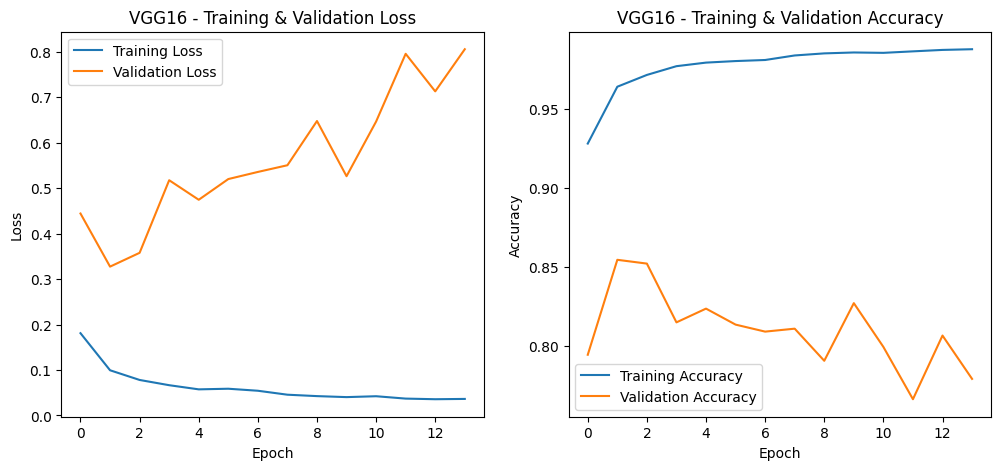

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

model_vgg16 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model_vgg16.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10, restore_best_weights=True)

history_vgg16 = model_vgg16.fit(
    tf_dataset_train,
    validation_data=tf_dataset_val,
    epochs=20,
    callbacks=[early_stopping]
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('VGG16 - Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 - Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
true_labels = []
predicted_labels = []

for images, labels in tf_dataset_test:
    predicted_probs = model_vgg16.predict(images, verbose=0)
    preds = np.argmax(predicted_probs, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(preds)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

Precision: 0.9384363295880149
Recall: 0.9539559785841761
F1 Score: 0.9461325151926367
Accuracy: 0.9287998128363097


### Comparison

The difference between the results of the standard CNN+MLP and the Transfer Learning methods was that the accuracy in standard CNN+MLP model was quite low initially, but it improves drastically later. The Transfer Learning methods showed us a fairly decent accuracy from epoch 1 which means that the pre trained weights sure did have a positive impact on the accuracy. The validation accuracy in each epoch was a bit varying in the standard model but in the pre trained models the validation accuracy was stable and did not vary much this could also be due to the learning rate set in the cnn+mlp model is .0001 instead of the deafult which is also justified by the flattenning of the validation graph in the later epochs.